# Tutorial - SIR Model

In [17]:
import numpy as np

For simulation, we need to specify three things about our system:

1. The stochastic rate constant vector<sup>*</sup>:

$$ k_j \equiv \text{the rate constant for reaction $j$}$$


2. The stoichiometry matrix $\nu$:

$$ \nu_{ij} \equiv \text{net change in species $i$ after unit progress in reaction $j$} $$

3. The kinetic order of each species in each reaction $O_{ij}$:

$$ O_{ij} \equiv \text{order of involvement of species $i$ in the rate law of reaction $j$} $$


<sup>*</sup> A stochastic rate constant denotes probability per unit time of a reaction per combination of potentially reactive elements. For instance, the rate constant for infection in an SIR model is usually denoted $\beta$. See section IIC of Exact Stochastic Simulation of Coupled Chemical Reactions, 1977, the original paper describing Gillespie's stochastic simulation algorithm for a more precise description. It is easy to get confused for reactions in which a single reactant species participates multiple times. 

## Specifying a system (by hand)

An SIR model has three species (S, I, and R) and two reactions:

Infection:
$$ \text{S} + \text{I} \to 2I \qquad k = \beta $$
Recovery:
$$ \text{I} \to R \qquad k = \gamma $$

In [37]:
# rate constant vector
beta = 3/1000
gamma = 1.0
k = np.array([beta, gamma])

# the stoichiometry matrix is always easier to contemplate by looking at its transpose, where rows correspond to reactions
N = np.array([
    # S, I, R
    [-1, 1, 0], # infection
    [0, -1, 1], # recovery
]).T

# kinetic involvement matrix
O = np.array([
    #S, I, R
    [1, 1, 0], # infection
    [0, 1, 0], # recovery
])

The above code is enough to start simulating, but let's do a quick pitstop to look at another way to specify a model, which is much more flexible and will make it easy to vary our parameters.

## Specifying a system (with `reactionmodel`)

This hybrid simulation package is designed to be used alongside [reactionmodel](https://github.com/tanderson11/reactionmodel/tree/main), a small module for simply specifying reaction networks. Here I show how it can be used to specify our SIR model.

In [38]:
from reactionmodel.model import Species, Reaction, Model

parameters={
    'beta': beta,
    'gamma': gamma,
}

S = Species('S')
I = Species('I')
R = Species('R')

infection = Reaction([S, I], [(I, 2)], k='beta') # (I, 2) means this reaction produces two infected individuals
recovery = Reaction([I], [R], k='gamma')

m = Model([S,I,R], [infection, recovery])

Now that we have built the model, we can use it to grab the rate constant vector, the stoichiometry matrix, and the kinetic order matrix.

In [39]:
k = m.get_k(parameters=parameters)
N = m.stoichiometry()
O = m.kinetic_order()

Evaluating expression: beta => 0.003
Evaluating expression: gamma => 1.0


## Choosing a simulator

### Gillespie

In [40]:
from hybrid.gillespie import GillespieSimulator

g_s = GillespieSimulator(
    k=k,
    N=N,
    kinetic_order_matrix=O,
)

### Tau-leaping

In [41]:
from hybrid.tau import TauLeapSimulator

t_s = TauLeapSimulator(
    k=k,
    N=N,
    kinetic_order_matrix=O,
    epsilon=0.01 # tau leaping uses the control parameter epsilon to dictate how much the propensities can change over a single leap
)

### Hybrid partitioning

In [42]:
from hybrid.hybrid import HybridSimulator, NThresholdPartitioner

h_s = HybridSimulator(
    k=k,
    N=N,
    kinetic_order_matrix=O,
    partition_function=NThresholdPartitioner(100.0) # this NThresholdPartitioner tells the simulator to treat species with more than 100 members as behaving deterministically
)

## Simulating

Let's pick our favorite of the above simulators

In [43]:
s = g_s

And simulate. We need three arguments:

1. `t_span`: the window of time between which to simulate:

$$ t_\text{span} = [t_\text{start}, t_\text{end}) $$

2. `y0`: the initial state vector of the system. The order of species is the same as the order of the rows of the stoichiometry matrix.

3. `rng`: a random number generator to use for all parts of the simulation. Usually you will just use `np.random.default_rng()` but if you want to reproduce the same behavior between runs, then specify a seed (`rng = np.random.default_rng(seed)`)

In [46]:
result = s.simulate(
    t_span=[0.0, 8.0],
    y0=np.array([990, 10, 0]),
    rng=np.random.default_rng()
)

<Axes: >

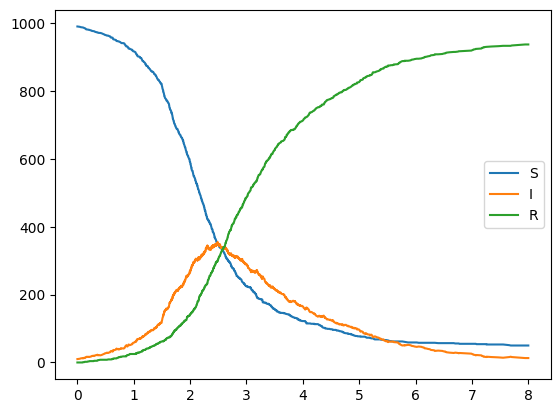

In [47]:
result.plot(['S', 'I', 'R'])